In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
import os
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Set global style for visualizations
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
df = pd.read_csv('sph6004_assignment1_data.csv')
# overview
print(df.shape)
print(df.head(5))
print(df.info())
missing_counts = df.isnull().sum()
print('Missing:',missing_counts)

column_name = 'id'
duplicates = df.duplicated(subset=[column_name], keep=False)


if duplicates.any():
    print(f"col '{column_name}' duplicate values exist in")
    print(df[duplicates])
else:
    print(f"col '{column_name}' are no duplicate values.")


(50920, 165)
         id  hospital_mortality  aki_stage gender  admission_age  \
0  39553978                   0          0      F      52.559969   
1  39765666                   0          0      F      76.486231   
2  37067082                   0          0      F      55.881486   
3  31205490                   0          0      F      46.275517   
4  37510196                   1          2      F      77.018296   

                     race  heart_rate_min  heart_rate_max  heart_rate_mean  \
0                   WHITE            91.0           105.0        96.500000   
1  BLACK/AFRICAN AMERICAN            68.0            80.0        73.636364   
2                   WHITE            78.0           106.0        93.200000   
3                   WHITE            55.0            91.0        79.480000   
4  BLACK/AFRICAN AMERICAN            38.0            80.0        71.392857   

   sbp_min  ...  ggt_max  ld_ldh_min  ld_ldh_max  gcs_min  gcs_motor  \
0     82.0  ...      NaN       173.0 

Missing data analysis:
                    Missing Values  Percentage
id                               0    0.000000
hospital_mortality               0    0.000000
aki_stage                        0    0.000000
gender                           0    0.000000
admission_age                    0    0.000000
...                            ...         ...
gcs_verbal                     513    1.007463
gcs_eyes                       378    0.742341
gcs_unable                     235    0.461508
height                       25909   50.881775
weight_admit                  1020    2.003142

[165 rows x 2 columns]


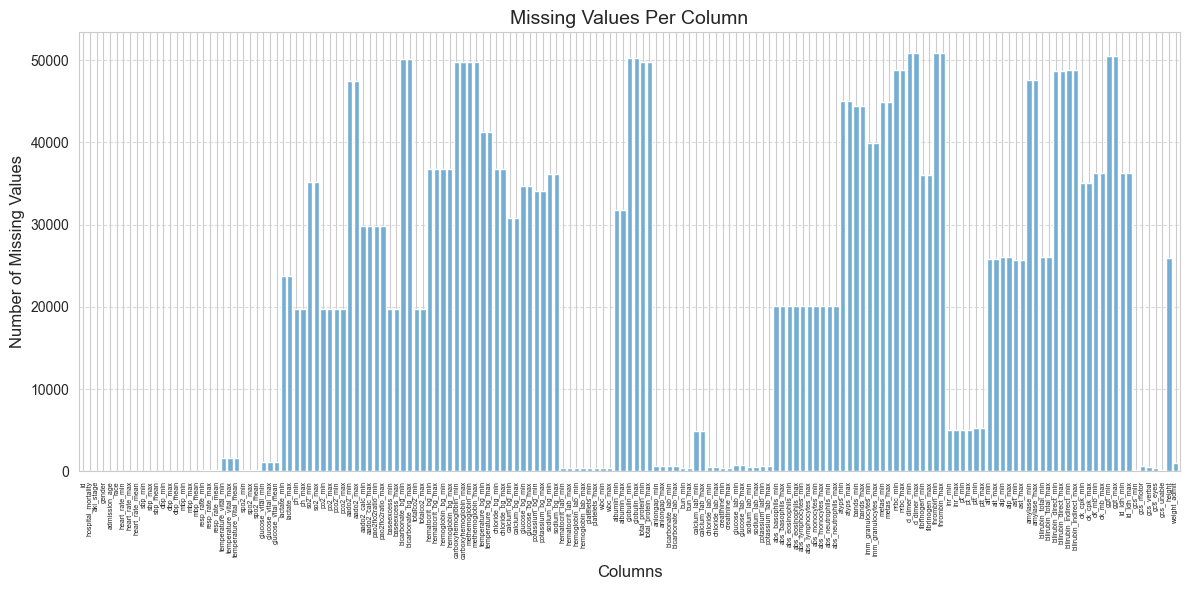


Fully Missing Columns:  Index([], dtype='object')
Partially Missing Columns:  Index(['heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min',
       'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'mbp_min',
       ...
       'ggt_max', 'ld_ldh_min', 'ld_ldh_max', 'gcs_min', 'gcs_motor',
       'gcs_verbal', 'gcs_eyes', 'gcs_unable', 'height', 'weight_admit'],
      dtype='object', length=159)


In [3]:
# 2. 分析缺失数据的类型
def analyze_missing_data(df):
    # 显示每列的缺失值个数和缺失比例
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / len(df)) * 100
    missing_summary = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
    
    # 输出缺失值统计
    print("Missing data analysis:")
    print(missing_summary)
    
    # 绘制缺失数据的可视化图
    fig, ax = plt.subplots(figsize=(12, 6))  # 更大的图表尺寸
    missing_summary['Missing Values'].plot(kind='bar', ax=ax, color='#74AED4', width=0.8)
    
    # 设置图表标题和标签
    ax.set_title('Missing Values Per Column', fontsize=14)
    ax.set_xlabel('Columns', fontsize=12)
    ax.set_ylabel('Number of Missing Values', fontsize=12)
    
    # 优化横轴标签
    ax.set_xticklabels(missing_summary.index, rotation=90, ha='center', fontsize=5)
    
    # 添加网格线
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 显示图表
    plt.tight_layout()  # 自动调整布局
    plt.show()

# 3. 判断缺失数据类型
def missing_data_type(df):
    missing_data = df.isnull()
    
    # 判断哪些列是完全缺失的（即所有值都缺失）
    fully_missing = df.columns[missing_data.all()]
    partially_missing = df.columns[missing_data.any() & ~missing_data.all()]
    
    print("\nFully Missing Columns: ", fully_missing)
    print("Partially Missing Columns: ", partially_missing)

# 4. 处理缺失数据
def handle_missing_data(df):
    # 对于完全缺失的列（全部为空的列），可以选择丢弃
    df = df.dropna(axis=1, how='all')
    
    # 对于部分缺失的列，我们可以选择不同的策略：
    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype == 'object':
                # 类别型数据使用众数进行填补
                imputer = SimpleImputer(strategy='most_frequent')
                df[col] = imputer.fit_transform(df[[col]])
            else:
                # 数值型数据使用均值进行填补
                imputer = SimpleImputer(strategy='mean')
                df[col] = imputer.fit_transform(df[[col]])
    
    print("\nMissing data has been handled (either dropped or imputed).")
    return df


# 1. 分析缺失数据
analyze_missing_data(df)

# 2. 判断缺失数据类型
missing_data_type(df)

In [4]:
mice_imputer = IterativeImputer(max_iter=50, random_state=42)
def categorize_race(race):
    race = str(race).upper()
    if 'BLACK' in race or 'AFRICAN AMERICAN' in race:
        return 'BLACK'
    elif 'WHITE' in race:
        return 'WHITE'
    elif 'ASIAN' in race or 'PACIFIC' in race:
        return 'ASIAN'
    else:
        return 'OTHER'
    
if os.path.exists('data_imputed.csv'):
    df = pd.read_csv('data_imputed.csv')
else:
    df = pd.read_csv('sph6004_assignment1_data.csv')
    df['race'] = df['race'].apply(categorize_race).map({'WHITE': 0, 'BLACK': 1, 'ASIAN': 2, 'OTHER': 3})
    df = df.drop(columns=['id'])
    df['gender'] = df['gender'].map({'F': 0, 'M': 1})
    # df = df.dropna(axis=1, thresh=int(0.3 * len(df)))
    # df = df.dropna(axis=0, how='any')

    # drop NA
    missing_ratio = df.isna().mean()
    col_threshold = 0.5
    cols_to_drop = missing_ratio[missing_ratio > col_threshold].index
    df.drop(columns=cols_to_drop, inplace=True)
    row_threshold = 0.5
    df = df[df.isna().mean(axis=1) <= row_threshold]

    # Avoid data leakage
    label_columns = ['hospital_mortality','aki_stage']
    concat_df = df[label_columns]
    imputed_df = df.drop(columns=label_columns)

    data_imputed = mice_imputer.fit_transform(imputed_df)
    df = pd.DataFrame(data_imputed, columns=imputed_df.columns)

    concat_df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, concat_df], axis=1)
    df.to_csv('data_imputed.csv', index=False)
print(df.shape)

(50564, 89)


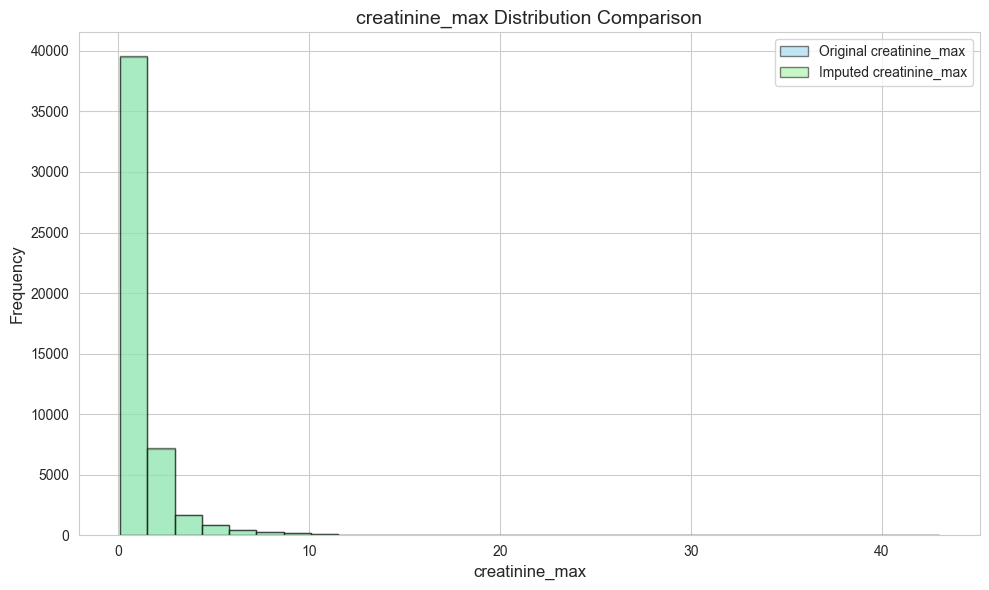

Kolmogorov-Smirnov test result for creatinine_max:
Statistic: 0.0005, p-value: 1.0000
No significant shift in distribution (p > 0.05).


In [5]:
from scipy.stats import ks_2samp
def load_data(original_file, imputed_file):
    original_df = pd.read_csv(original_file)
    imputed_df = pd.read_csv(imputed_file)
    return original_df, imputed_df

# Kolmogorov-Smirnov检验
def ks_test(original_data, imputed_data):
    stat, p_value = ks_2samp(original_data.dropna(), imputed_data.dropna())
    return stat, p_value

# 绘制直方图并进行分布对比
def plot_distribution_comparison(original_data, imputed_data, variable_name):
    plt.figure(figsize=(10, 6))
    
    plt.hist(original_data.dropna(), bins=30, alpha=0.5, label=f'Original {variable_name}', color='skyblue', edgecolor='black')
    plt.hist(imputed_data.dropna(), bins=30, alpha=0.5, label=f'Imputed {variable_name}', color='lightgreen', edgecolor='black')
    
    # 设置图表标题和标签
    plt.title(f'{variable_name} Distribution Comparison', fontsize=14)
    plt.xlabel(variable_name, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    
    # 显示图表
    plt.tight_layout()
    plt.show()


def compare_distributions(original_file, imputed_file, variable_name):

    original_df, imputed_df = load_data(original_file, imputed_file)
    
    original_data = original_df[variable_name]
    imputed_data = imputed_df[variable_name]
    
    # 绘制分布图
    plot_distribution_comparison(original_data, imputed_data, variable_name)
    
    # 进行Kolmogorov-Smirnov检验
    stat, p_value = ks_test(original_data, imputed_data)
    print(f"Kolmogorov-Smirnov test result for {variable_name}:")
    print(f"Statistic: {stat:.4f}, p-value: {p_value:.4f}")
    

    if p_value > 0.05:
        print("No significant shift in distribution (p > 0.05).")
    else:
        print("Significant shift in distribution (p <= 0.05).")

original_file = 'sph6004_assignment1_data.csv' 
imputed_file = 'data_imputed.csv'  
variable_name = 'creatinine_max'  

compare_distributions(original_file, imputed_file, variable_name)

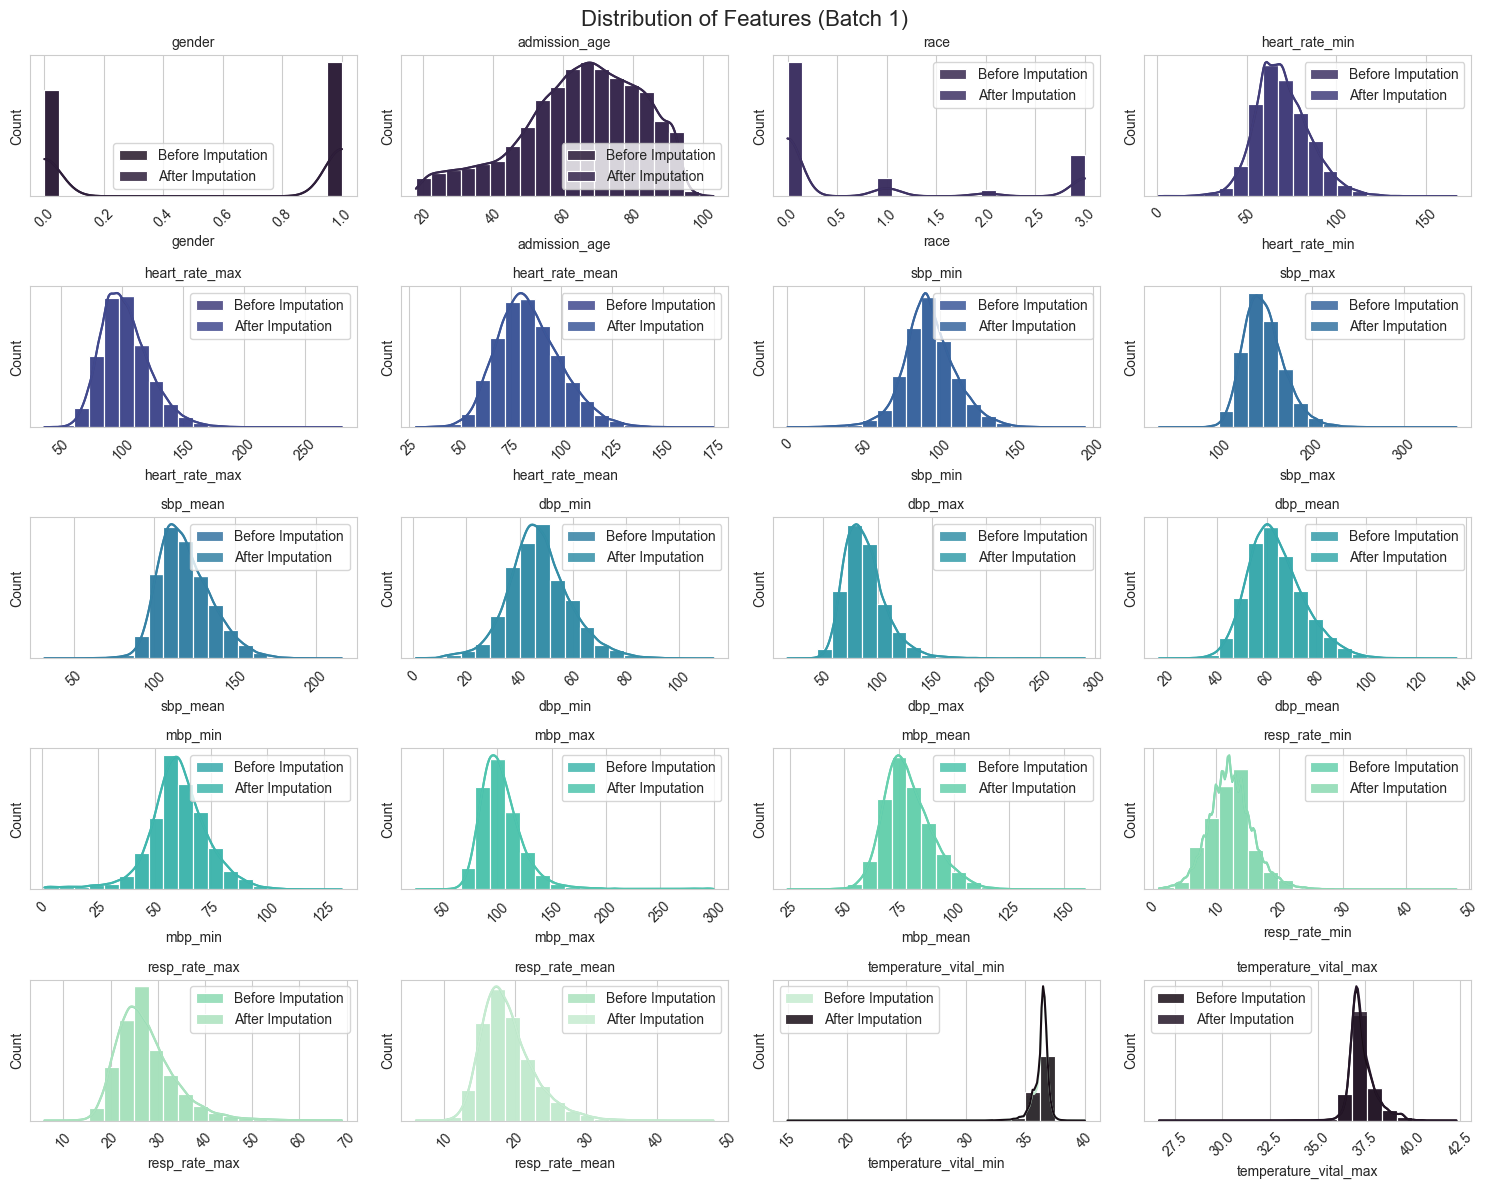

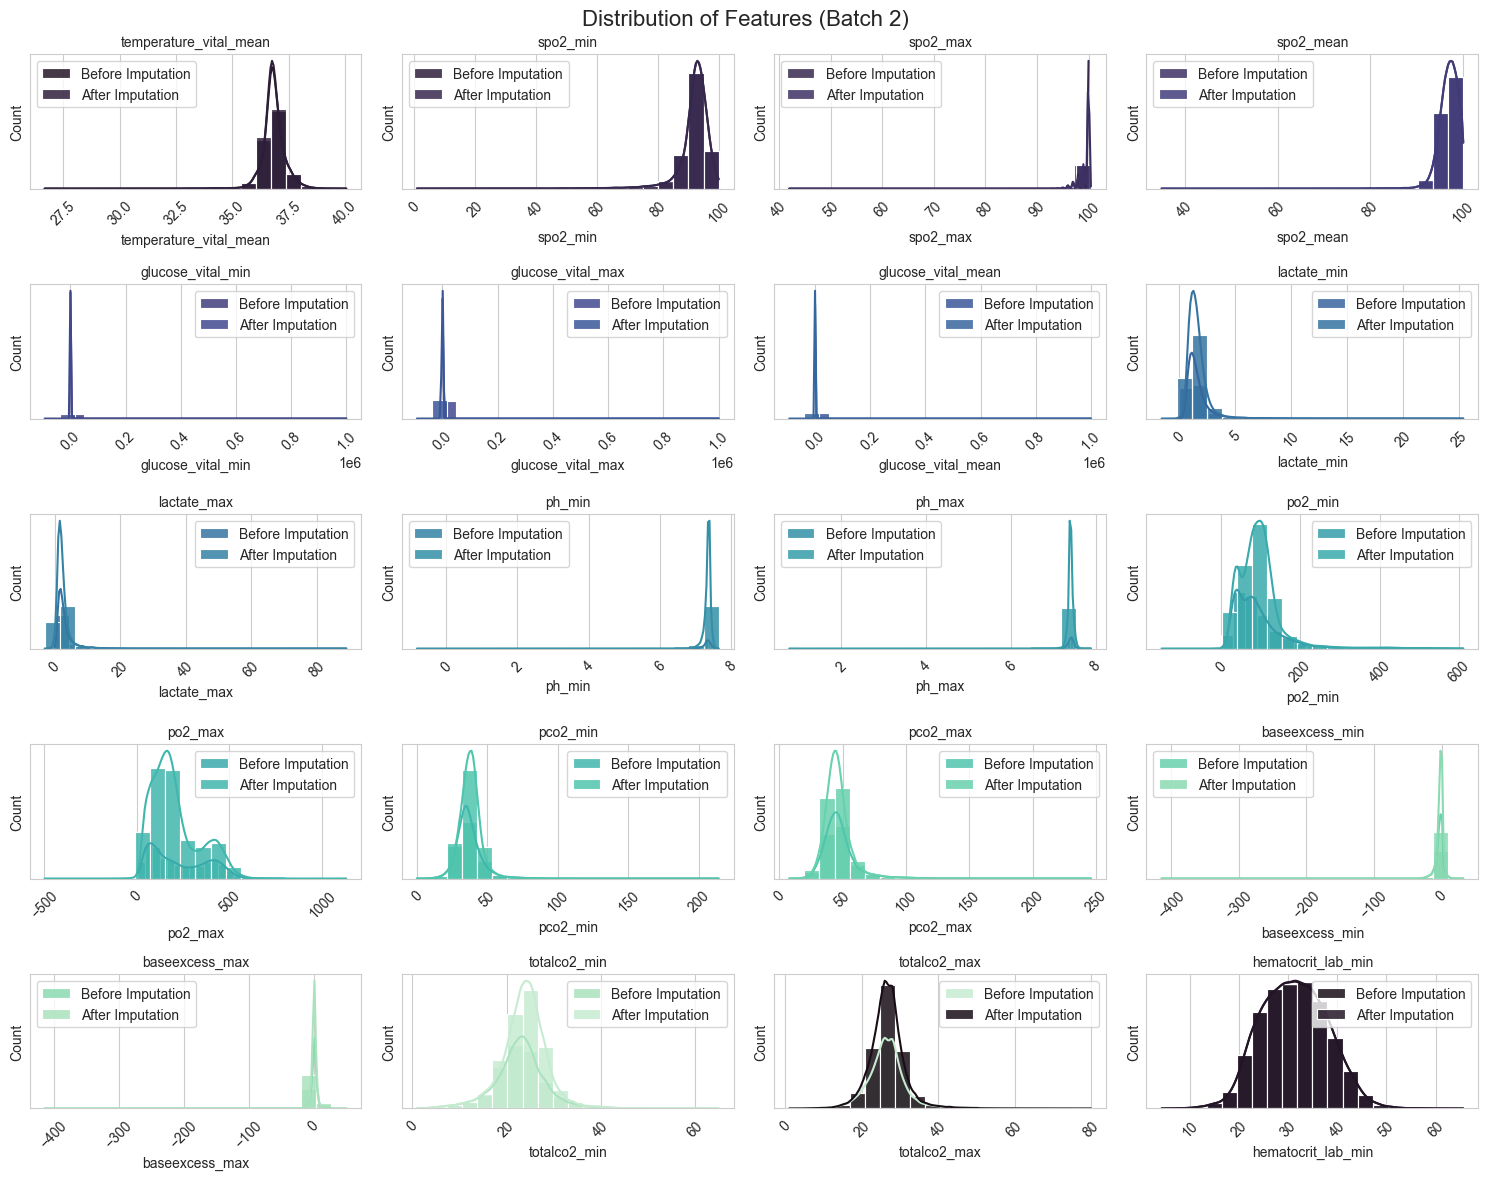

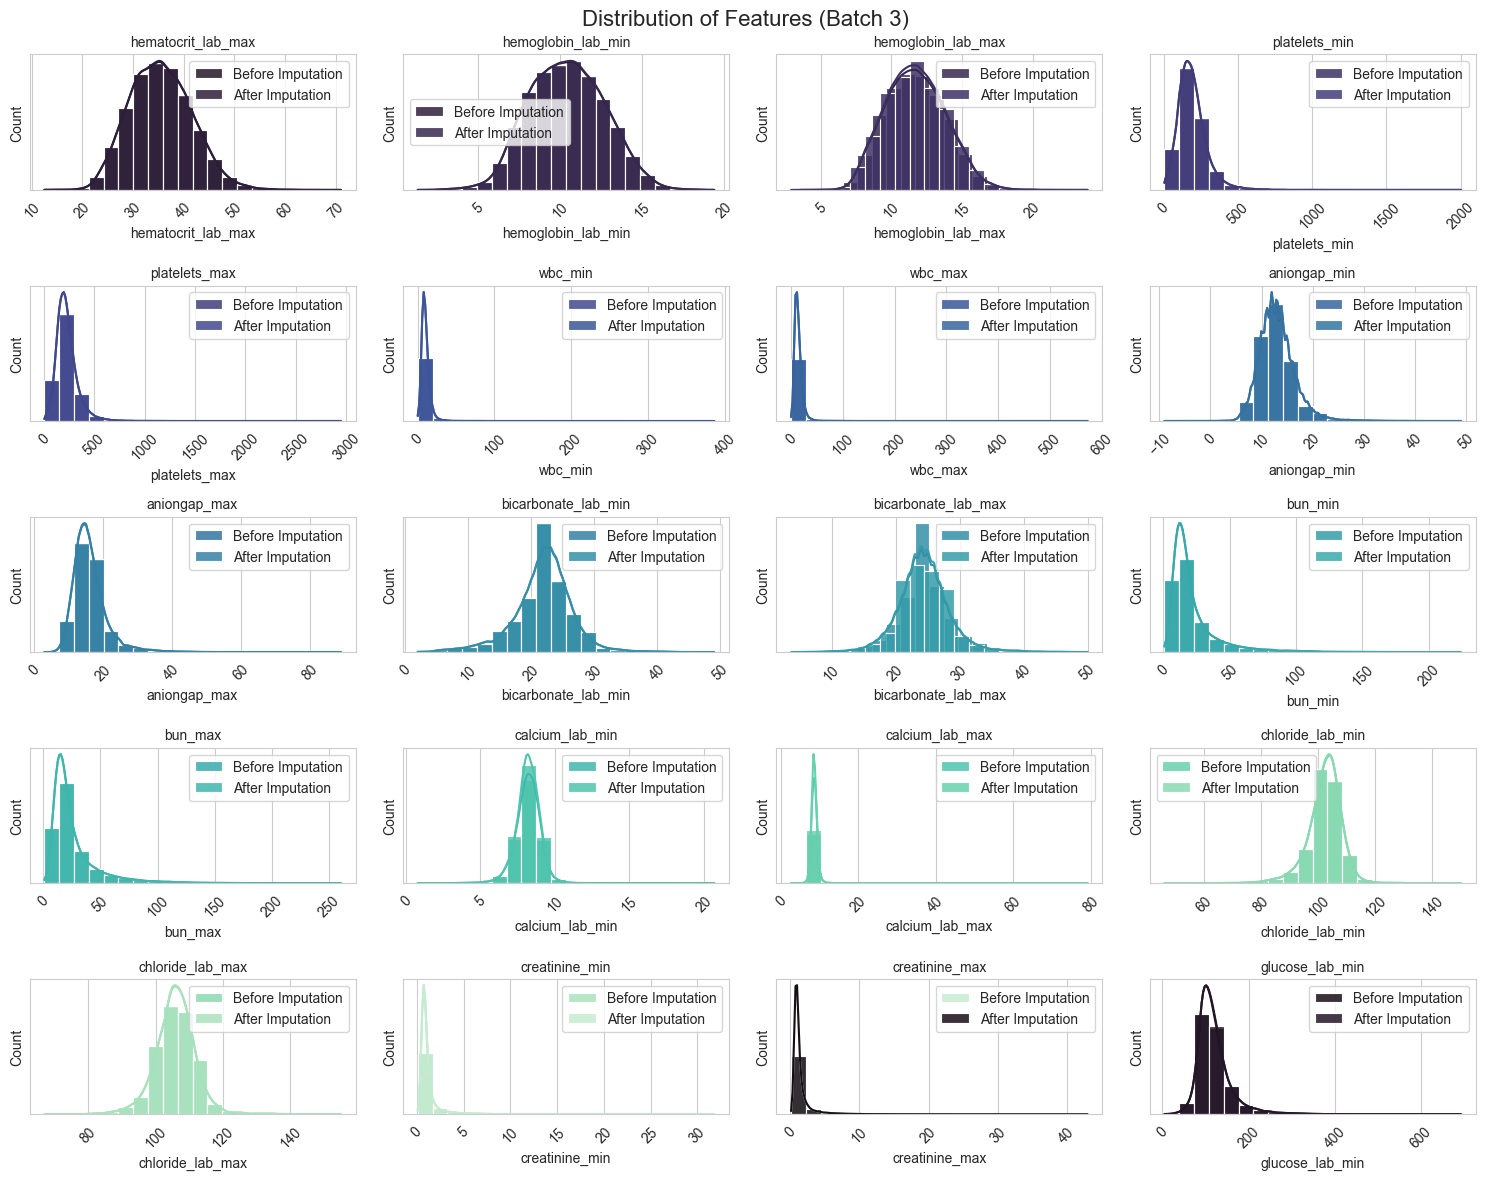

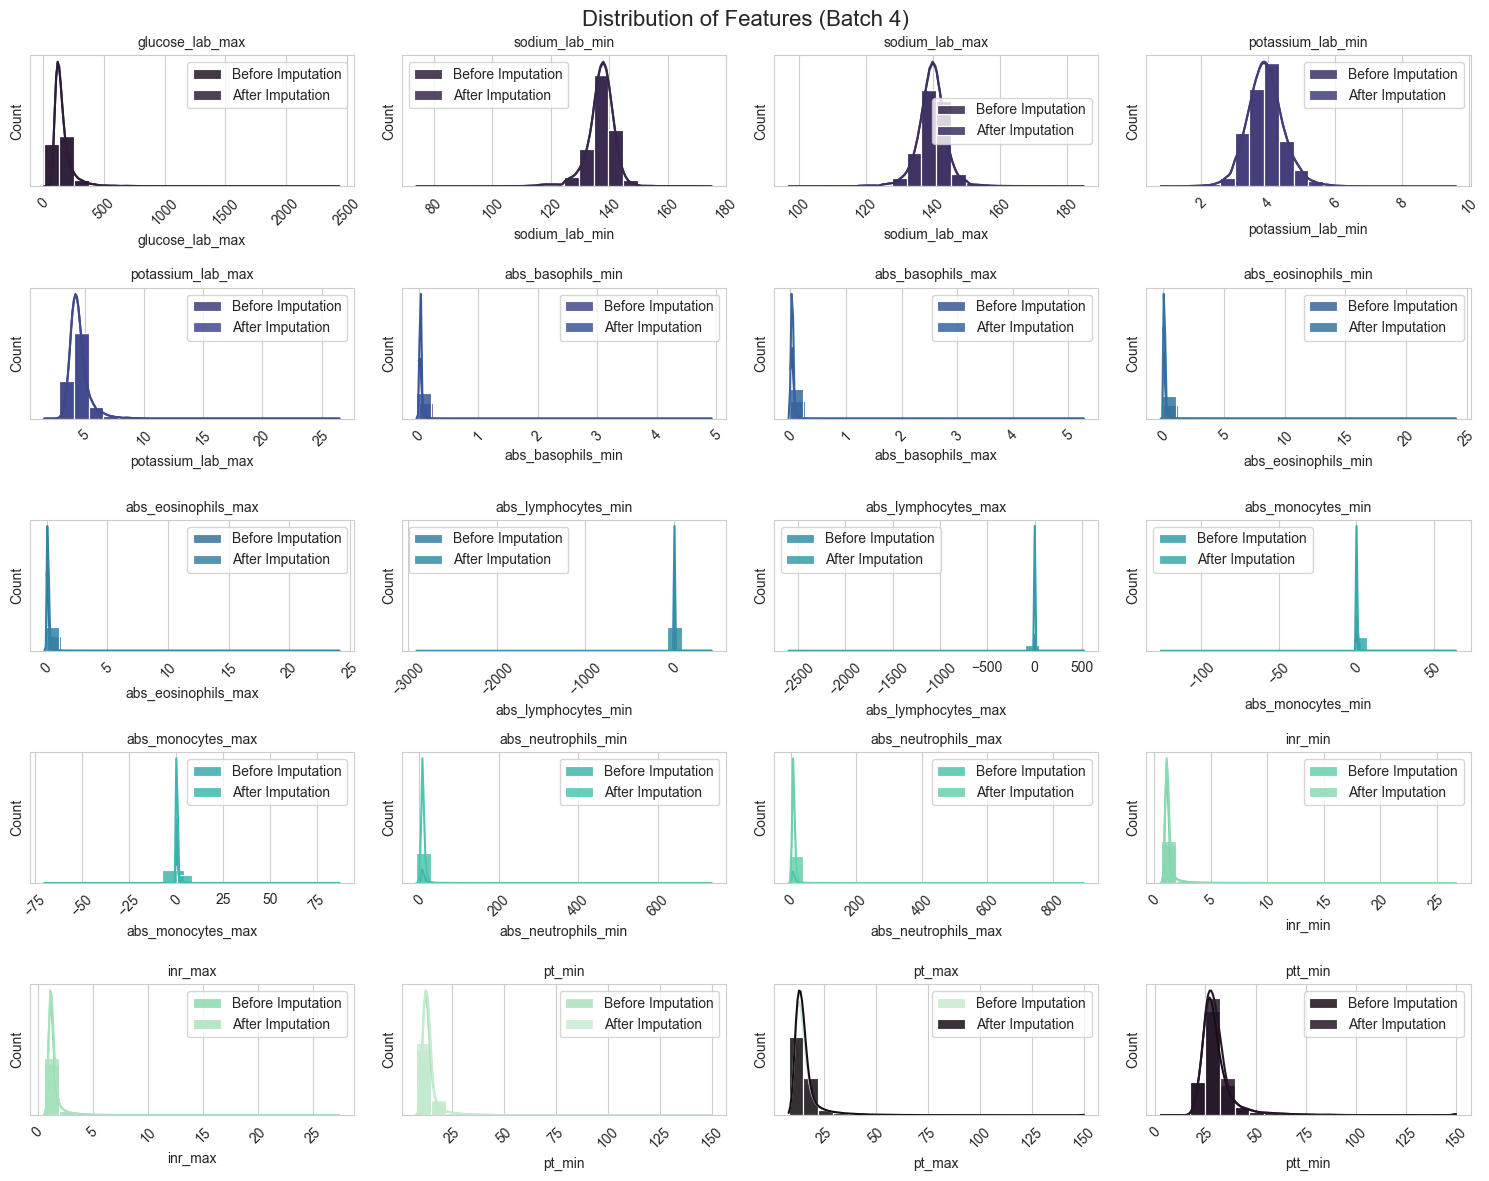

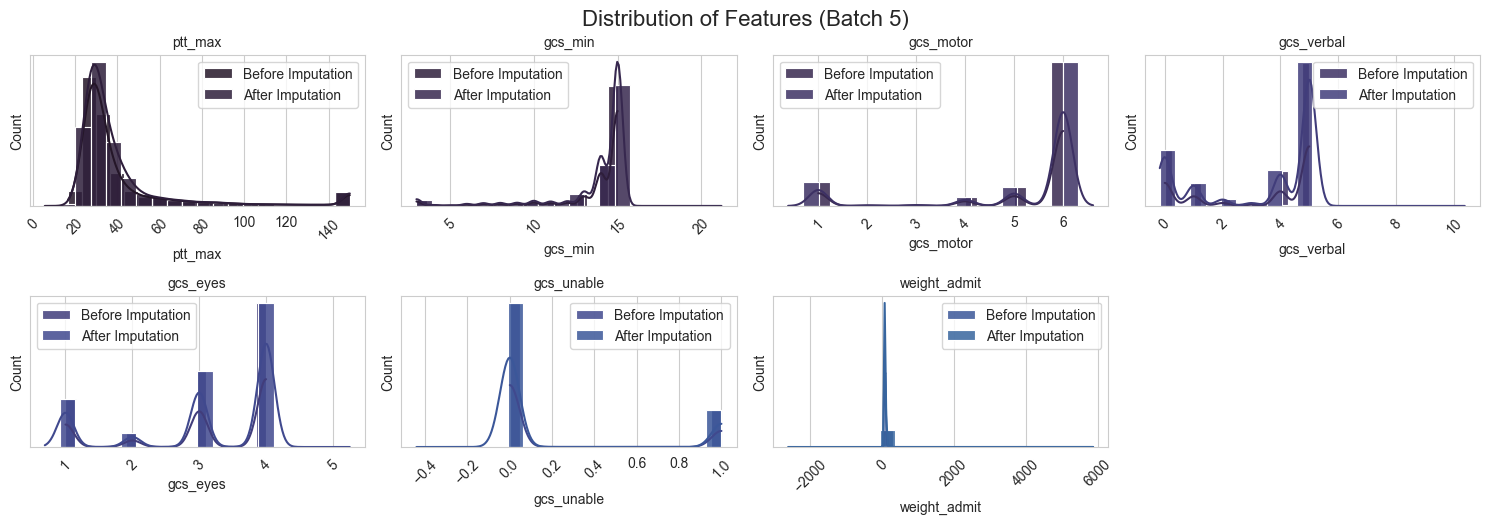

In [6]:
#Histogram for Understanding Distributions
# 加载插补前后的数据
df_before = pd.read_csv('sph6004_assignment1_data.csv')
df_after = pd.read_csv('data_imputed.csv')

def categorize_race(race):
    race = str(race).upper()
    if 'BLACK' in race or 'AFRICAN AMERICAN' in race:
        return 'BLACK'
    elif 'WHITE' in race:
        return 'WHITE'
    elif 'ASIAN' in race or 'PACIFIC' in race:
        return 'ASIAN'
    else:
        return 'OTHER'
df_before['race'] = df_before['race'].apply(categorize_race).map({'WHITE': 0, 'BLACK': 1, 'ASIAN': 2, 'OTHER': 3})
df_before = df_before.drop(columns=['id'])
df_before['gender'] = df_before['gender'].map({'F': 0, 'M': 1})

# drop NA
missing_ratio = df_before.isna().mean()
col_threshold = 0.5
cols_to_drop = missing_ratio[missing_ratio > col_threshold].index
df_before.drop(columns=cols_to_drop, inplace=True)
row_threshold = 0.5
df_before = df_before[df_before.isna().mean(axis=1) <= row_threshold]

label_columns = ['hospital_mortality','aki_stage']
df_before = df_before.drop(columns=label_columns)
df_after = df_after.drop(columns=label_columns)


num_cols_before = df_before.select_dtypes(include=['number']).columns
num_cols_after = df_after.select_dtypes(include=['number']).columns
assert list(num_cols_before) == list(num_cols_after), "Columns mismatch between before and after imputation datasets!"


features_per_batch = 20
num_batches = (len(num_cols_before) + features_per_batch - 1) // features_per_batch

colors = sns.color_palette("mako", features_per_batch)


for batch in range(num_batches):
    start = batch * features_per_batch
    end = min(start + features_per_batch, len(num_cols_before))
    batch_cols = num_cols_before[start:end]

    plt.figure(figsize=(15, 12))
    for i, col in enumerate(batch_cols, 1):
        plt.subplot(5, 4, i)  
        # 插补前的分布
        sns.histplot(df_before[col], bins=20, kde=True, color=colors[i % len(colors)], alpha=0.85, label='Before Imputation')
        
        # 插补后的分布
        sns.histplot(df_after[col], bins=20, kde=True, color=colors[(i + 1) % len(colors)], alpha=0.85, label='After Imputation')
        
        plt.title(f"{col}", fontsize=10)
        plt.xticks(rotation=45)
        plt.yticks([]) 
        plt.legend()

    plt.suptitle(f"Distribution of Features (Batch {batch + 1})", fontsize=16)
    plt.tight_layout()
    plt.show()


Outlier Detection:
gender: 0 outliers detected
admission_age: 0 outliers detected
race: 0 outliers detected
heart_rate_min: 17 outliers detected
heart_rate_max: 47 outliers detected
heart_rate_mean: 6 outliers detected
sbp_min: 78 outliers detected
sbp_max: 76 outliers detected
sbp_mean: 14 outliers detected
dbp_min: 15 outliers detected
dbp_max: 182 outliers detected
dbp_mean: 15 outliers detected
mbp_min: 282 outliers detected
mbp_max: 757 outliers detected
mbp_mean: 26 outliers detected
resp_rate_min: 56 outliers detected
resp_rate_max: 157 outliers detected
resp_rate_mean: 81 outliers detected
temperature_vital_min: 833 outliers detected
temperature_vital_max: 373 outliers detected
temperature_vital_mean: 567 outliers detected
spo2_min: 1527 outliers detected
spo2_max: 574 outliers detected
spo2_mean: 302 outliers detected
glucose_vital_min: 1190 outliers detected
glucose_vital_max: 1429 outliers detected
glucose_vital_mean: 1340 outliers detected
lactate_min: 1107 outliers detect

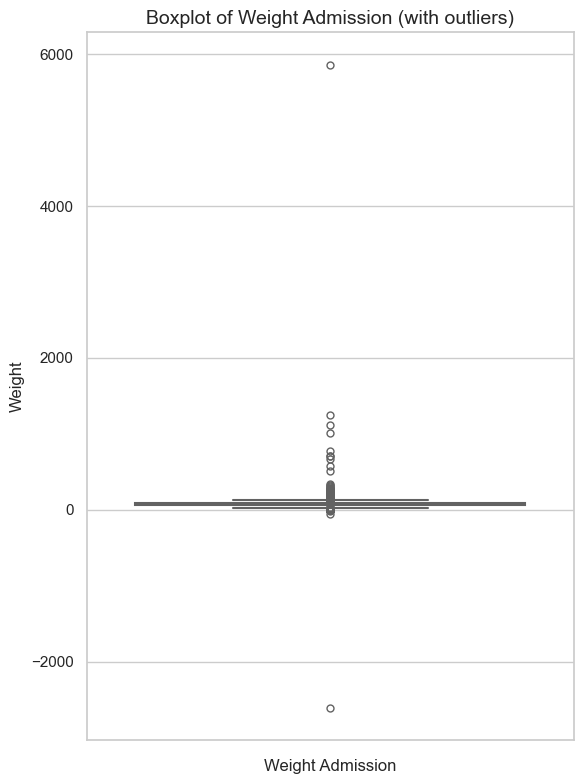

In [7]:
# Define function to detect outliers
def detect_outliers_iqr(data, column,th = 1.5):
    """
    Detect outliers in a numerical column using the Interquartile Range (IQR) method.
    """
    Q1 = data[column].quantile(0.25)  # 25th percentile
    Q3 = data[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - th * IQR
    upper_bound = Q3 + th * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Apply outlier detection to numerical columns
num_cols = df.select_dtypes(include=['number']).columns
print("\nOutlier Detection:")
for col in num_cols:
    outliers = detect_outliers_iqr(df, col ,3)
    print(f"{col}: {len(outliers)} outliers detected")

# 使用箱线图查看变量分布及异常值
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(6, 8))  # 根据需要调整大小
sns.boxplot(data=df['weight_admit'], color='#74AED4', fliersize=5, linewidth=1.5)

# 标题和标签
plt.title('Boxplot of Weight Admission (with outliers)', fontsize=14)
plt.xlabel('Weight Admission', fontsize=12)
plt.ylabel('Weight', fontsize=12)

# 显示图形
plt.tight_layout()
plt.show()

There are significant outliers in the weight variable

             gender  admission_age          race  heart_rate_min  \
count  50564.000000   50564.000000  50564.000000    50564.000000   
mean       0.559054      64.973298      0.772328       69.920285   
std        0.496505      17.251431      1.215152       15.112230   
min        0.000000      18.002527      0.000000        1.000000   
25%        0.000000      54.542021      0.000000       60.000000   
50%        1.000000      66.734484      0.000000       69.000000   
75%        1.000000      78.159368      1.000000       79.000000   
max        1.000000     102.865603      3.000000      167.000000   

       heart_rate_max  heart_rate_mean       sbp_min       sbp_max  \
count    50564.000000     50564.000000  50564.000000  50564.000000   
mean       102.523017        84.284145     93.192281    148.246284   
std         20.453719        15.700535     17.495316     22.701065   
min         36.000000        28.500000      0.108000     34.000000   
25%         88.000000        73.25925

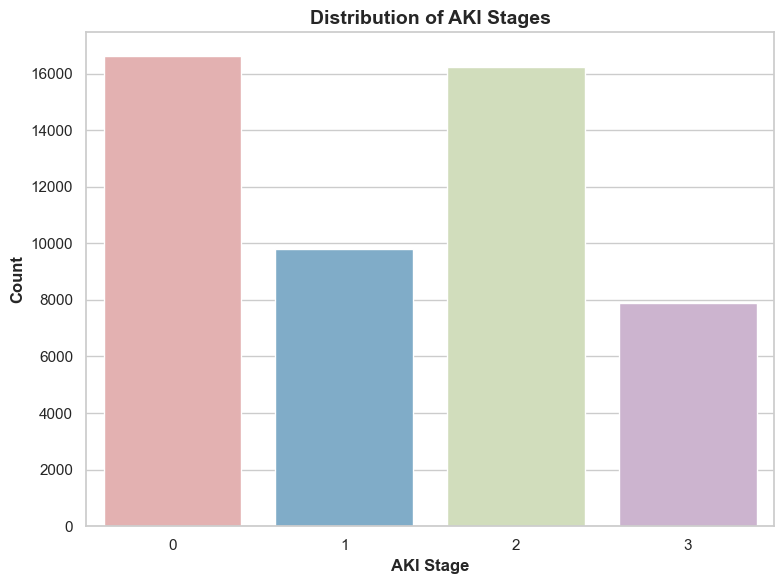

aki_stage
0    16632
2    16234
1     9793
3     7905
Name: count, dtype: int64


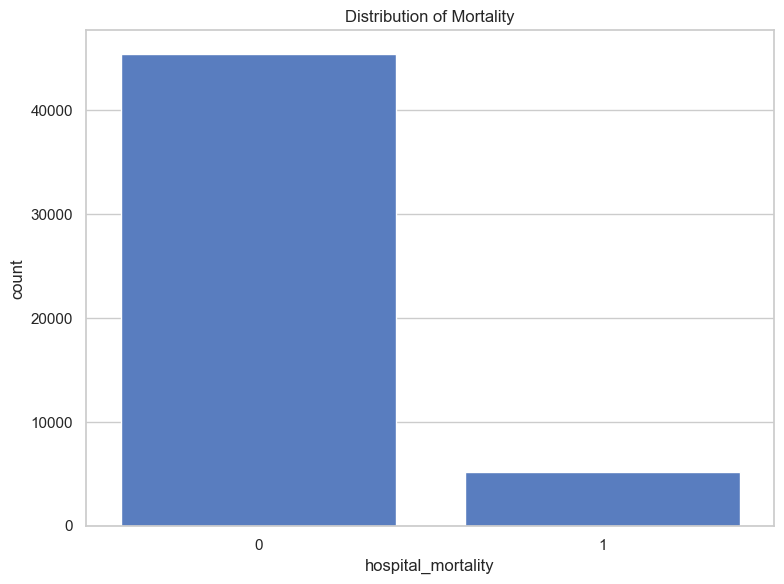

In [8]:
# 查看所有数值型列的统计摘要
print(df.describe())

# 计算特定变量的统计量（例如年龄和肌酐）
mean_age = df['creatinine_min'].mean()
median_age = df['creatinine_min'].median()
std_age = df['creatinine_min'].std()
print(f"Creatinine_min mean={mean_age:.2f}, median={median_age}, std={std_age:.2f}")

mean_creatinine = df['creatinine_max'].mean()
median_creatinine = df['creatinine_max'].median()
print(f"creatinine_max mean={mean_creatinine:.2f}, median={median_creatinine:.2f}")

# # 计算与目标变量（如AKI阶段或死亡率）相关的特征的相关系数
# correlation_with_target = df.corr()['aki_stage'].sort_values(ascending=False)
# print('Correlation coefficients of features associated with AKI stages:')
# print(correlation_with_target)

sns.set(style="whitegrid", palette="muted")

colors = ['#ECA8A9', '#74AED4', '#D3E2B7', '#CFAFD4', '#F7C97E']

plt.figure(figsize=(8, 6))
sns.countplot(x='aki_stage', data=df, palette=colors)

plt.title('Distribution of AKI Stages', fontsize=14, fontweight='bold')
plt.xlabel('AKI Stage', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()
aki_stage_counts = df['aki_stage'].value_counts()
print(aki_stage_counts)


plt.figure(figsize=(8, 6))
sns.countplot(x='hospital_mortality', data=df)
plt.title('Distribution of Mortality')
plt.tight_layout()
plt.show()

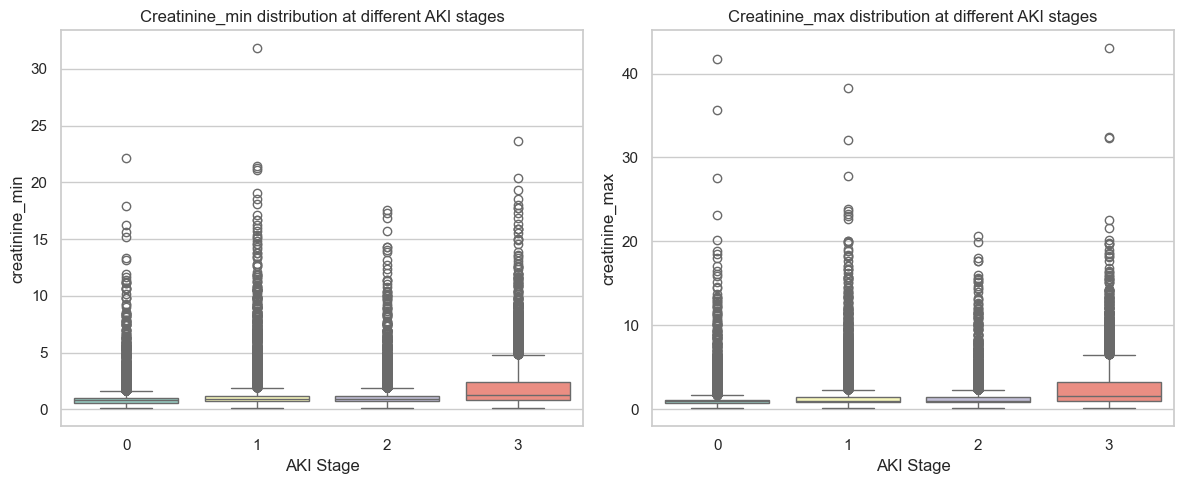

In [9]:
# The boxplots of creatinine levels in patients with different AKI stages were compared
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 行，2 列，画布大小为 (12, 5)

# creatinine_min
sns.boxplot(x='aki_stage', y='creatinine_min', data=df, palette="Set3", ax=axes[0])
axes[0].set_xlabel('AKI Stage')
axes[0].set_ylabel('creatinine_min')
axes[0].set_title('Creatinine_min distribution at different AKI stages')

# creatinine_max
sns.boxplot(x='aki_stage', y='creatinine_max', data=df, palette="Set3", ax=axes[1])
axes[1].set_xlabel('AKI Stage')
axes[1].set_ylabel('creatinine_max')
axes[1].set_title('Creatinine_max distribution at different AKI stages')
plt.tight_layout()
plt.show()

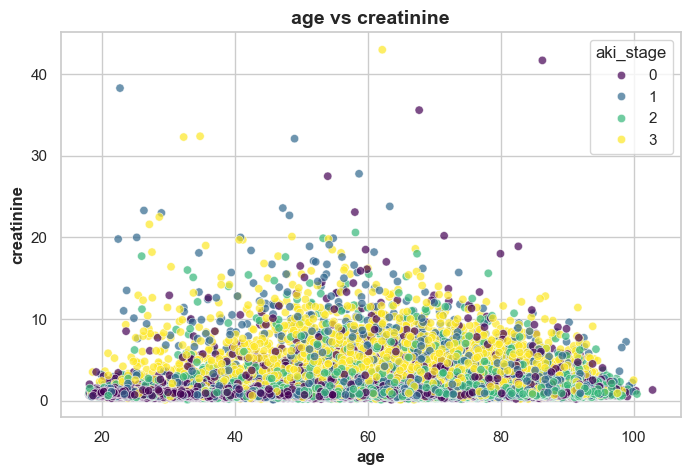

In [10]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['admission_age'], y=df['creatinine_max'], hue=df['aki_stage'], palette='viridis',alpha=0.7)
plt.title("age vs creatinine", fontsize=14, fontweight='bold')
plt.xlabel("age", fontsize=12, fontweight='bold')
plt.ylabel("creatinine", fontsize=12, fontweight='bold')
plt.show()

In [11]:
# 计算所有数值型变量的皮尔逊相关系数矩阵
corr_matrix = df.corr(method='pearson')
print(corr_matrix.head())  # 打印相关矩阵的前几行

# 提取AKI分期(假设列名为 'aki_stage')与其他变量的相关系数，并按绝对相关度排序
aki_corr = corr_matrix['aki_stage'].drop('aki_stage').sort_values(key=abs, ascending=False)
print("AKI分期与其他变量的Pearson相关系数：")
print(aki_corr.head(10))  # 列出绝对值最高的几个相关系数

# 如果需要计算Spearman相关系数（非参数相关），可以指定method='spearman'
spearman_corr = df.corr(method='spearman')
print("Spearman相关系数矩阵中的AKI相关：")
print(spearman_corr['aki_stage'].drop('aki_stage').sort_values(key=abs, ascending=False).head(10))

                  gender  admission_age      race  heart_rate_min  \
gender          1.000000      -0.069939  0.018122       -0.044732   
admission_age  -0.069939       1.000000 -0.131018       -0.171960   
race            0.018122      -0.131018  1.000000        0.015696   
heart_rate_min -0.044732      -0.171960  0.015696        1.000000   
heart_rate_max -0.037218      -0.159428  0.043130        0.599101   

                heart_rate_max  heart_rate_mean   sbp_min   sbp_max  sbp_mean  \
gender               -0.037218        -0.043266  0.028437 -0.008292  0.002697   
admission_age        -0.159428        -0.186961 -0.100461  0.114877  0.027669   
race                  0.043130         0.034780 -0.006800  0.016689  0.005879   
heart_rate_min        0.599101         0.867847  0.001102 -0.100047 -0.071704   
heart_rate_max        1.000000         0.837241 -0.150844  0.024451 -0.094607   

                 dbp_min  ...   ptt_min   ptt_max   gcs_min  gcs_motor  \
gender          0.113935

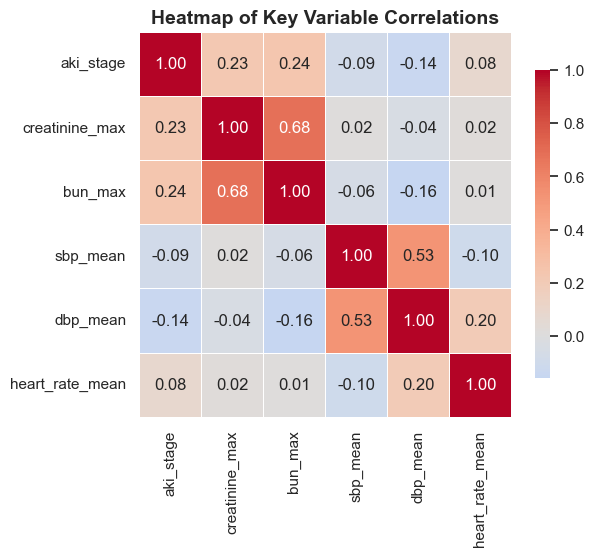

In [12]:
# Heat map
vars_of_interest = ['aki_stage', 'creatinine_max', 'bun_max', 'sbp_mean', 'dbp_mean', 'heart_rate_mean']
corr_matrix_subset = df[vars_of_interest].corr(method='pearson')
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix_subset, annot=True, fmt=".2f", cmap="coolwarm",center=0, linewidths=0.5, linecolor='white', cbar_kws={"shrink": 0.8})
plt.title('Heatmap of Key Variable Correlations', fontsize=14, fontweight='bold')
plt.show()

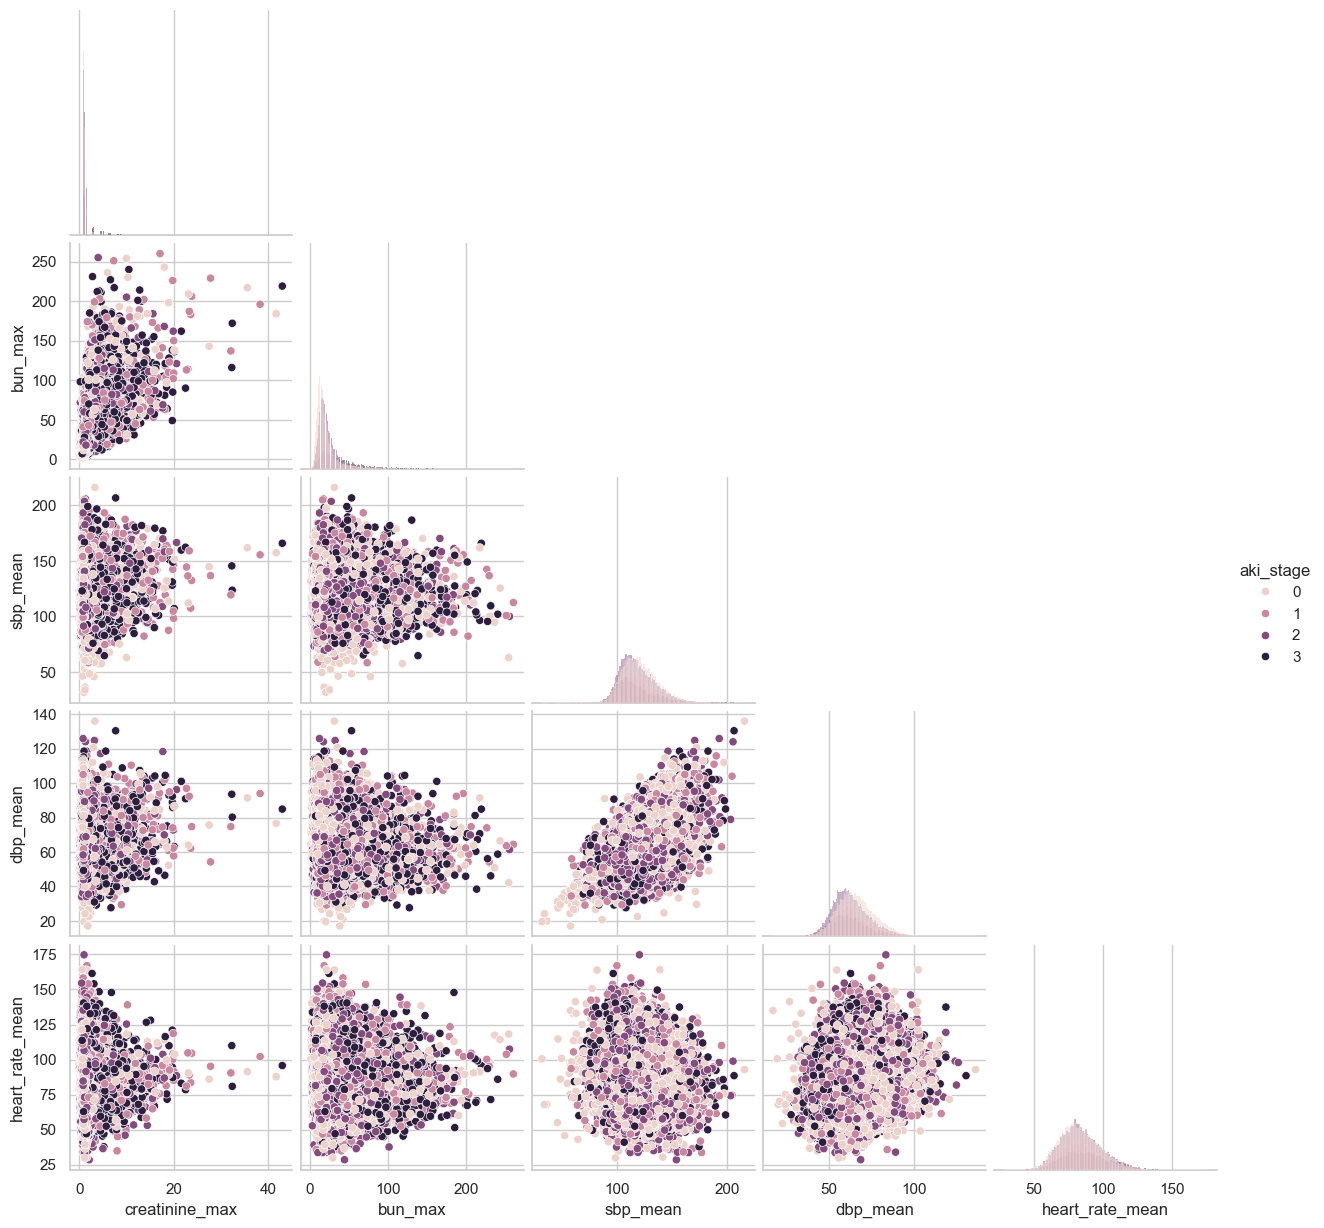

In [13]:
sns.pairplot(df[vars_of_interest], hue='aki_stage', corner=True, diag_kind='hist')
plt.show()

In [14]:
#t检验/ANOVA

In [15]:
from scipy import stats

# 示例1：t检验比较无AKI (aki_stage=0) 与 有AKI (aki_stage>0) 两组肌酐均值差异
group_no_aki = df[df['aki_stage'] == 0]['creatinine_max']
group_aki = df[df['aki_stage'] > 0]['creatinine_max']
t_stat, p_val = stats.ttest_ind(group_no_aki, group_aki, equal_var=False)  # Welch t-test 不假定方差齐
print(f"无AKI vs 有AKI：t统计量={t_stat:.2f}, p值={p_val:.4f}")

# 示例2：ANOVA 比较 AKI 0、1、2、3 各组肌酐均值差异
group0 = df[df['aki_stage'] == 0]['creatinine_max']
group1 = df[df['aki_stage'] == 1]['creatinine_max']
group2 = df[df['aki_stage'] == 2]['creatinine_max']
group3 = df[df['aki_stage'] == 3]['creatinine_max']
F_stat, p_val = stats.f_oneway(group0, group1, group2, group3)
print(f"ANOVA 检验：F统计量={F_stat:.2f}, p值={p_val:.4f}")

无AKI vs 有AKI：t统计量=-40.14, p值=0.0000
ANOVA 检验：F统计量=1685.04, p值=0.0000


In [16]:
from scipy.stats import chi2_contingency

# 构建 AKI分期 (行) vs 性别 (列) 的列联表
contingency_table = pd.crosstab(df['aki_stage'], df['gender'])
print(contingency_table)

# 执行卡方检验
chi2, p, dof, expected = chi2_contingency(contingency_table.values)
print(f"Chi-square={chi2:.2f}, degrees of freedom={dof}, P value={p:.4f}")

gender      0.0   1.0
aki_stage            
0          7816  8816
1          4040  5753
2          6908  9326
3          3532  4373
Chi-square=105.52, degrees of freedom=3, P value=0.0000


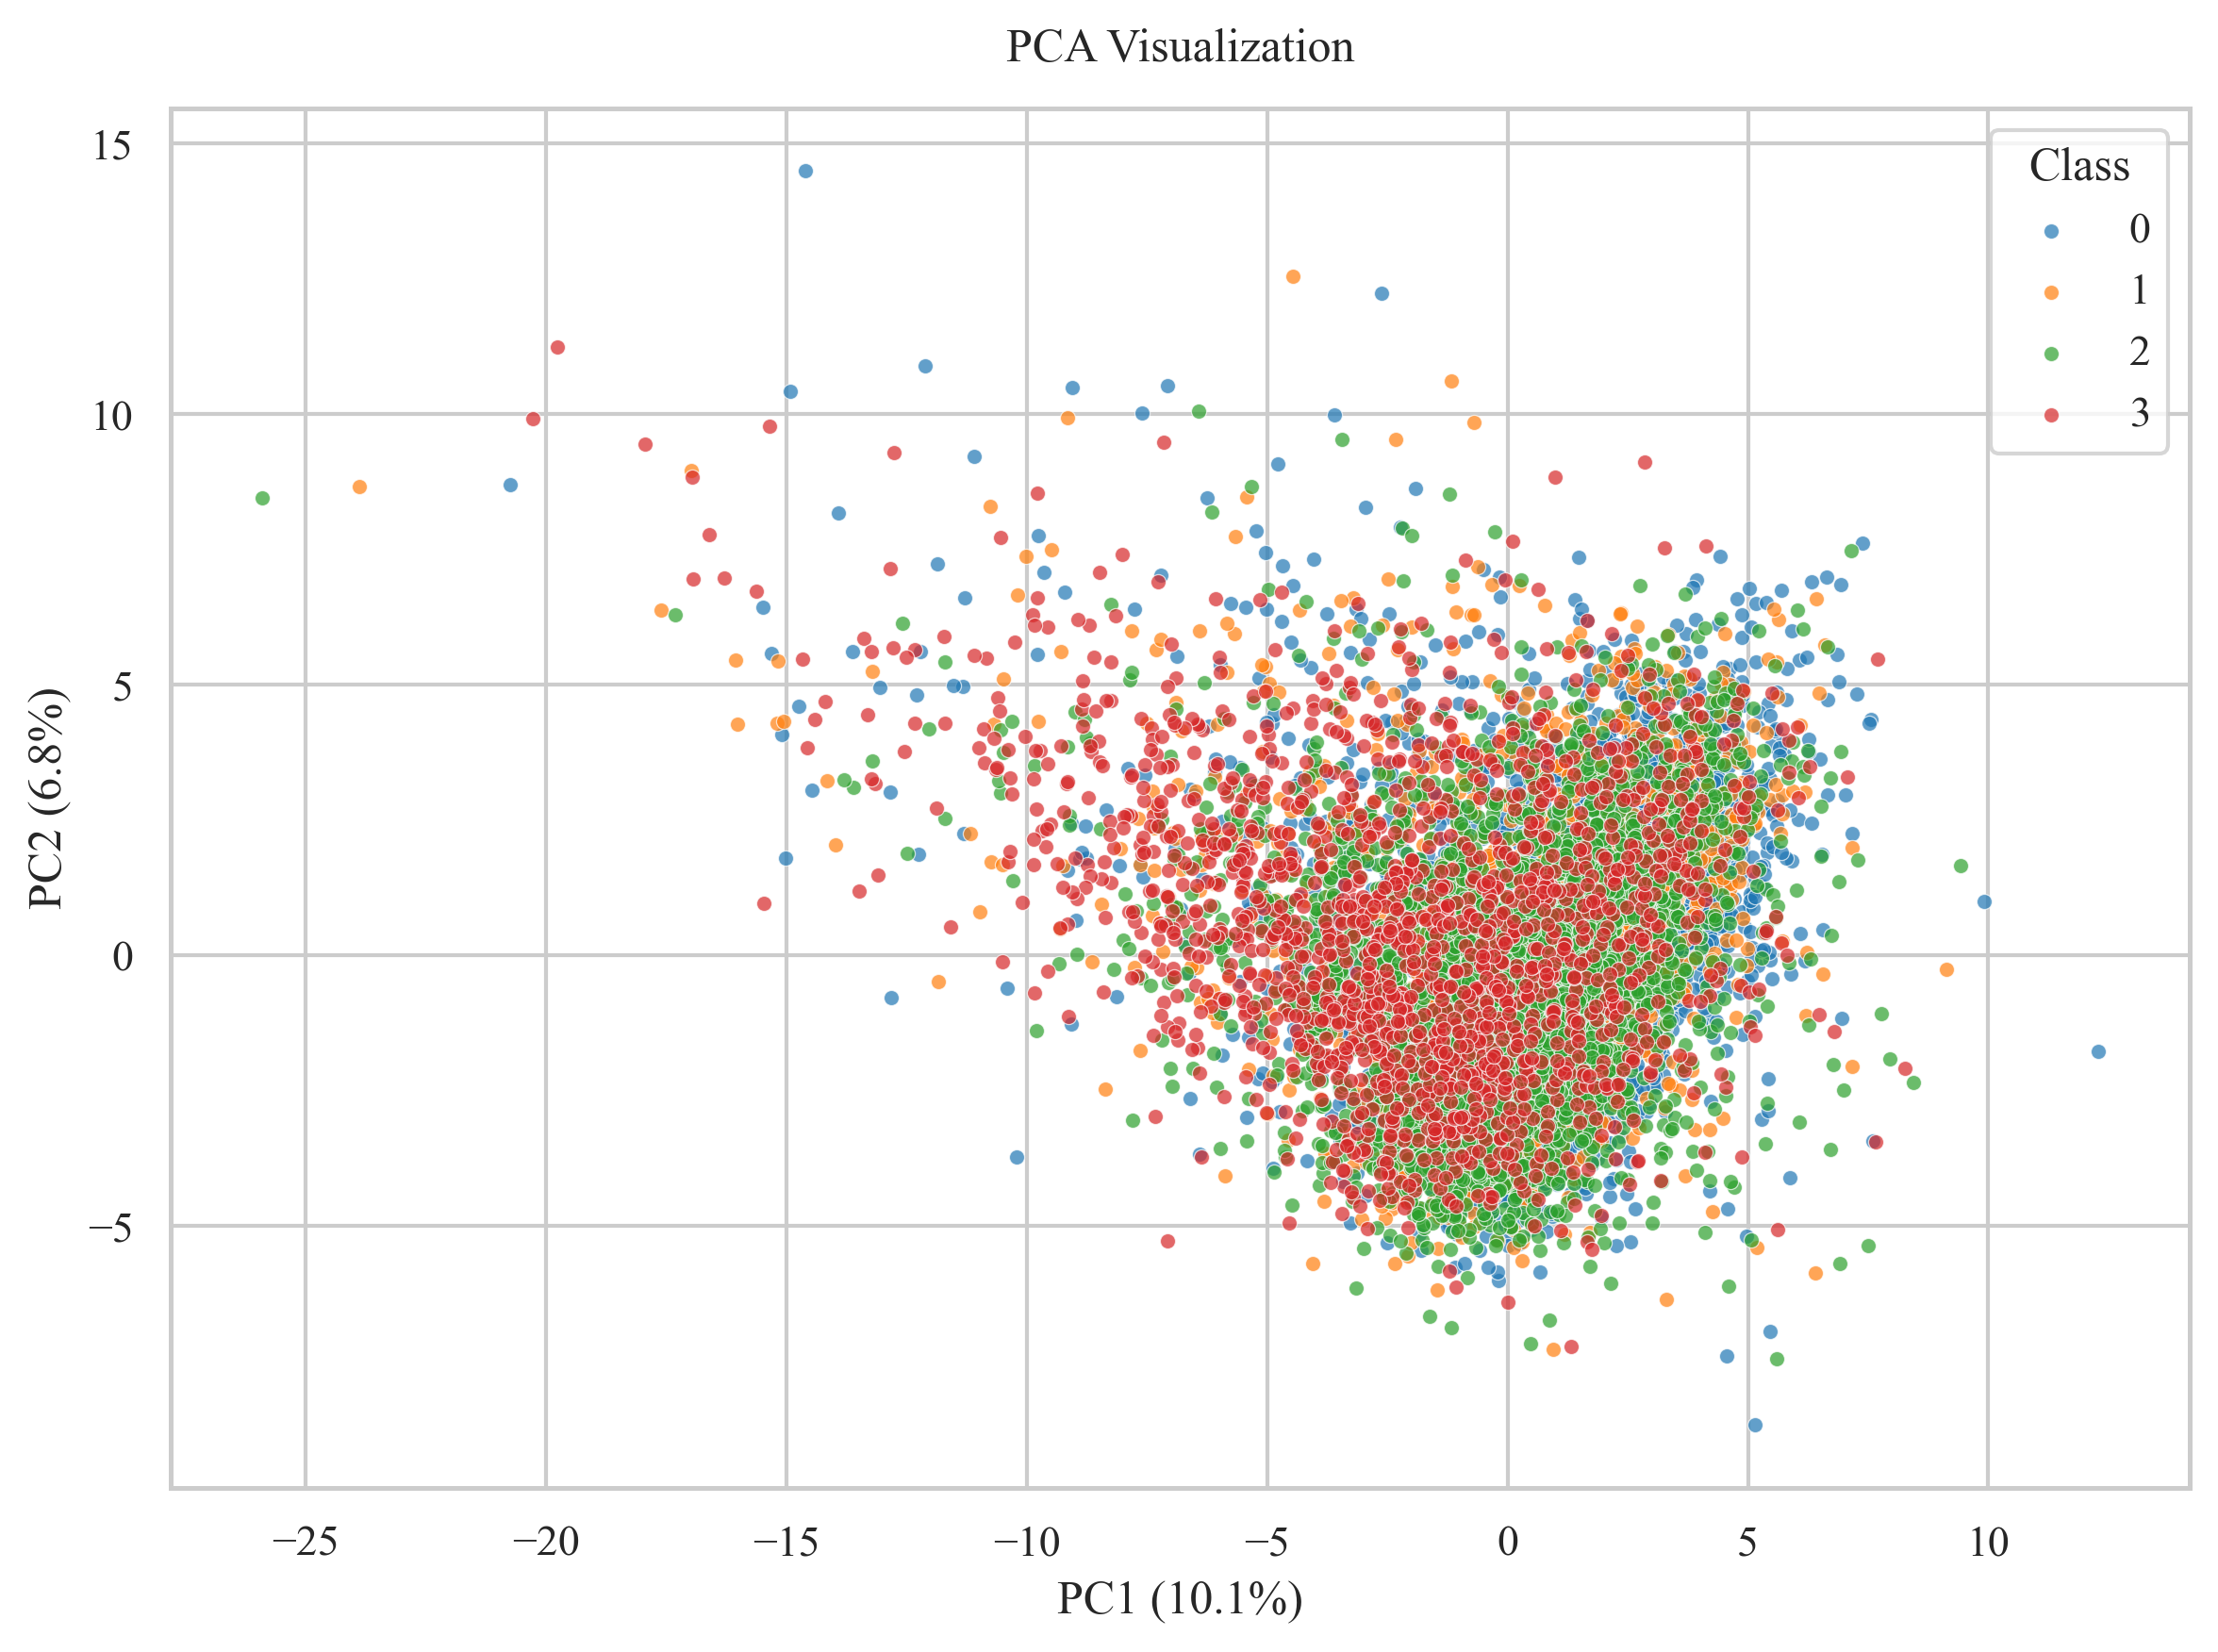

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
# 1. 加载数据
selected_features = ['admission_age', 'race', 'heart_rate_max', 'sbp_min', 'sbp_max',
       'mbp_min', 'mbp_max', 'resp_rate_max', 'temperature_vital_min',
       'temperature_vital_max', 'spo2_min', 'spo2_max', 'glucose_vital_max',
       'glucose_vital_mean', 'lactate_max', 'ph_min', 'po2_max',
       'baseexcess_min', 'baseexcess_max', 'hematocrit_lab_min',
       'hematocrit_lab_max', 'hemoglobin_lab_min', 'hemoglobin_lab_max',
       'platelets_min', 'platelets_max', 'wbc_min', 'bicarbonate_lab_min',
       'bun_min', 'bun_max', 'chloride_lab_min', 'chloride_lab_max',
       'creatinine_min', 'creatinine_max', 'sodium_lab_min',
       'abs_basophils_min', 'abs_eosinophils_max', 'abs_monocytes_min',
       'abs_neutrophils_min', 'pt_max', 'ptt_min', 'ptt_max', 'gcs_min',
       'gcs_verbal', 'gcs_unable', 'weight_admit', 'scr_delta', 'scr_ratio',
       'high_lactate_flag', 'siri_score', 'egfr', 'interaction_fever_wbc']
X = pd.read_csv('X_test.csv').loc[:, selected_features]
y = pd.read_csv('y_test.csv')['aki_stage']#.map({0: 0, 1: 1, 2:1, 3:1})#.values.ravel()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# 设置科研绘图风格
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

def plot_pca_comparison(X_raw, y, output_path='pca_comparison.png'):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    classes = le.classes_

    # 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)

    # PCA降维
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # 创建图像
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    # 定义绘图参数
    plot_params = {
        'alpha': 0.7,
        's': 15,
        'edgecolor': 'w',
        'linewidth': 0.3,
    }

    # 为每个类别单独绘制
    colors = plt.cm.tab10(range(len(classes)))
    for i, cls in enumerate(classes):
        mask = (y_encoded == i)
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   color=colors[i], label=cls, **plot_params)
    # 添加坐标轴标签和标题
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    ax.set_title('PCA Visualization', pad=12)

    # 添加图注
    ax.legend(title='Class', loc='best', frameon=True)

    # 优化布局并保存
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()

plot_pca_comparison(X, y, output_path='pca_comparison.png')